# **Text Spam Classification with Deep Averaging Networks and Transformer Models**

Link to Google Collab notebook: https://colab.research.google.com/drive/1w2vrb2wgOa8pG22f0ErZ2FdnTpW9jFRb?usp=sharing

## Objective
Develop and benchmark a **spam detection pipeline** for text messages, starting with a **Deep Averaging Network (DAN) baseline** and progressing to a **DistilBERT-based transformer classifier** for state-of-the-art performance.

## Scope
- Text preprocessing and tokenization for both classical and transformer-based models  
- Baseline training with **DAN** for fast, interpretable results  
- Fine-tuning of **DistilBERT + linear classifier** with weighted loss to handle class imbalance  
- Comparative evaluation using **Accuracy, Precision, Recall, Specificity, F1-score, ROC-AUC, PR-AUC**  
- Threshold optimization for optimal trade-off between sensitivity and false positives  

## Deliverable
An end-to-end, reproducible **spam detection framework** that demonstrates the evolution from lightweight neural baselines (DAN) to **transformer-based architectures** (DistilBERT) for robust, real-world text classification.


### **1. Import libraries and dataset**

In [ ]:
# 1. Install libraries
!pip install torch torchvision torchaudio transformers tiktoken --quiet

# 2. Import libraries
import pandas as pd
import numpy as np
import string
import re
import tiktoken
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import DistilBertTokenizerFast, DistilBertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


In [ ]:
file_path="spam.csv"
df = pd.read_csv(file_path,encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.shape

(5572, 5)

In [ ]:
# Rename columns to be meaningul and drop useless columns
df.rename(columns = {"v1": "label", "v2": "text"}, inplace = True)
df = df[["label","text"]].copy()
df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Check for missing values
df.isna().sum()

,0
label,0
text,0


In [ ]:
# Drop duplicates
print(f"There are {df.duplicated().sum()} duplicates in the dataset")
df.drop_duplicates(inplace = True)

There are 403 duplicates in the dataset


In [ ]:
# Check class distribution
df['label'].value_counts()

,count
label,
0,4516
1,653


### **2. Text Cleaning, Splitting and Tokenization**

####Cleaning

In [ ]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Strip whitespace
    text = text.strip()

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)
df.head()

,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


#### Train test split


In [ ]:
# 1. Split with stratify
x = df["clean_text"]
y = df["label"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.30, shuffle = True, random_state = 42, stratify = y)

In [ ]:
# 2. Reset indices
train_x = train_x.reset_index(drop=True)
test_x = test_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

#### Encode into Token IDs

In [ ]:
# Turn each message into a list of token IDs (integers)

tokenizer = tiktoken.get_encoding("cl100k_base")  # tokenizer used in GPT-4

def encode_texts(texts):
    return [tokenizer.encode(text) for text in texts]

train_tokens = encode_texts(train_x)
test_tokens = encode_texts(test_x)

In [ ]:
# Check average sequence length

seq_lens = [len(seq) for seq in train_tokens]

print("Mean:", np.mean(seq_lens))
print("Median:", np.median(seq_lens))
print("95th percentile:", np.percentile(seq_lens, 95))
print("Max:", np.max(seq_lens))

Mean: 18.425649530127142
Median: 14.0
95th percentile: 44.0
Max: 127


In [ ]:
seq_lens = [len(seq) for seq in test_tokens]

print("Mean:", np.mean(seq_lens))
print("Median:", np.median(seq_lens))
print("95th percentile:", np.percentile(seq_lens, 95))
print("Max:", np.max(seq_lens))

Mean: 18.77820760799484
Median: 14.0
95th percentile: 44.0
Max: 196


The average length of a text is around 18 tokens.
The length of 95% of texts is less than or equal to 44 tokens.

####Pad Sequences (use max_length = 44)

In [ ]:
# Pad sequences to a fixed length to make sure all message codes are the same length so the model can batch them together
# Neural networks require fixed-size inputs, but texts are naturally different lengths
# so we cut long ones and pad short ones with 0s (a "blank" token)

def pad_sequences(sequences, max_length=44):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

# Apply padding
padded_train_tokens = pad_sequences(train_tokens)
padded_test_tokens = pad_sequences(test_tokens)

### **3. Create PyTorch dataset**

In [ ]:
# Wrap data in a PyTorch-friendly format to be used in training
# PyTorch expects a Dataset object that can return one sample at a time

from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, token_lists, labels):
        self.texts = torch.tensor(token_lists, dtype=torch.long)
        self.labels = torch.tensor(labels.tolist(), dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = SpamDataset(padded_train_tokens, train_y)
test_dataset = SpamDataset(padded_test_tokens, test_y)

In [ ]:
# Group data into mini-batches of size 32 and shuffle during training
# Mini-batching speeds up training and stabilize gradient updates
# Shuffling avoids overfitting to data order

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

### **4. Build the model**

Deep Averaging Network (DAN) / bag-of-embeddings classifier:

- Architecture: Simple feed-forward deep learning model built with PyTorch.

- Embedding layer: Learns dense vector representations of tokens during training.

- Pooling: Applies average pooling to summarize all token embeddings into one fixed-size vector.

- Classifier: A linear layer + sigmoid outputs the probability that a message is spam.

- Training: End-to-end training with gradient descent, minimizing binary cross-entropy loss.

- Key idea: Captures semantic meaning of words via embeddings and classifies based on their overall presence/combination.

- Strengths: Lightweight, fast to train, effective baseline for text classification.

In [ ]:
# Define a simple model that:
# 1. Turns tokens into embeddings (word meanings)
# 2. Pools them into one vector (averages)
# 3. Predicts spam or ham with a final layer

# Architecture: Embedding → Pooling → Fully Connected → Sigmoid

import torch.nn as nn

class SpamClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=32):
        super().__init__()

        # 1. Embedding layer
        # Converts each token ID into a dense vector (word meaning).
        # vocab_size = number of unique words
        # embedding_dim = size of each word vector (here: 32)
        # padding_idx=0 ensures padding tokens are ignored in training
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0) #learns word representaions during training

        # 2. Pooling layer
        # AdaptiveAvgPool1d(1): averages across all tokens in the sequence.
        # Summarizes variable-length sentences into a single fixed-length vector.
        self.pooling = nn.AdaptiveAvgPool1d(1) #summarize sequence into 1 vector

        # 3. Fully connected (Linear) layer
        # Maps the pooled vector (size=embedding_dim) → single logit (size=1).
        # This single output is the "spam score" before activation.
        self.fc = nn.Linear(embedding_dim, 1) #maps to a probability [0, 1]

    def forward(self, x):
        # Input x: (B, T)  where B = batch size, T = sequence length (tokens)

        embedded = self.embedding(x)  # (B, T, E) → E = embedding_dim
                                      # Example: 32-dim vector for each token

        # Permute to (B, E, T) to match pooling input format
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(-1)  # (B, E)

        # Linear → Sigmoid to get probability [0,1]
        return torch.sigmoid(self.fc(pooled)) # (B, 1)

In [ ]:
# get the total N of unique tokens used by the tokenizer (GPT-4's cl100k_base vocab has ~100k tokens)
vocab_size = tokenizer.n_vocab
# initialize the spam classifier model, telling it how many unique toekn embeddings it should learn
model = SpamClassifier(vocab_size)

### **5. Train the model**

In [ ]:
# === Training Loop ===
# Goal: minimize prediction error by updating model weights
# Steps: Forward pass -> Compute loss -> Backpropagate -> Update weights

import torch.optim as optim

# Loss function: Binary Cross-Entropy
# Measures difference between predicted probability (0–1) and true label (0 or 1)
criterion = nn.BCELoss()

# Optimizer: Adam with learning rate = 1e-3
# Updates model weights using gradients from backpropagation
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model, dataloader):
    model.train()                 # Put model in training mode (activates dropout, etc.)
    running = 0.0                 # Track cumulative loss over epoch

    for x, y in dataloader:       # Iterate over each mini-batch
        optimizer.zero_grad()     # Reset gradients (avoid accumulation)

        out = model(x).squeeze()  # Forward pass: predict probabilities for batch
        loss = criterion(out, y)  # Compare predictions vs true labels → compute loss

        loss.backward()           # Backpropagation: compute gradients
        optimizer.step()          # Gradient descent: update weights

        running += loss.item()    # Accumulate batch loss (convert tensor → float)

    # Return average loss across all mini-batches
    return running / len(dataloader)


### **6. Evaluate the model performance**

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
)

# Safer metrics (avoid warnings when no positives predicted early on)
def evaluate(model, dataloader, return_raw=False):
    model.eval()
    preds, labels, probs = [], [], []
    with torch.no_grad():
        for x, y in dataloader:
            out = model(x).squeeze()          # predicted probability (sigmoid output)
            p = (out > 0.5).int()
            preds += p.tolist()
            labels += y.int().tolist()
            probs  += out.tolist()

    acc  = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score(labels, preds, zero_division=0)
    f1   = f1_score(labels, preds, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Useful for imbalanced spam detection
    try:
        roc_auc = roc_auc_score(labels, probs)
    except ValueError:
        roc_auc = float("nan")
    ap = average_precision_score(labels, probs)  # PR-AUC (Average Precision)

    if return_raw:
        return acc, prec, rec, spec, f1, roc_auc, ap, labels, preds, probs
    return acc, prec, rec, spec, f1, roc_auc, ap



Epoch 1 - Loss: 0.2529 | Acc: 0.9607 | Prec: 0.9787 | Rec: 0.7041 | Spec: 0.9978 | F1: 0.8190 | ROC-AUC: 0.9376 | PR-AUC: 0.8702
Epoch 2 - Loss: 0.2075 | Acc: 0.9645 | Prec: 0.9796 | Rec: 0.7347 | Spec: 0.9978 | F1: 0.8397 | ROC-AUC: 0.9478 | PR-AUC: 0.8929
Epoch 3 - Loss: 0.1745 | Acc: 0.9703 | Prec: 0.9808 | Rec: 0.7806 | Spec: 0.9978 | F1: 0.8693 | ROC-AUC: 0.9544 | PR-AUC: 0.9079
Epoch 4 - Loss: 0.1503 | Acc: 0.9710 | Prec: 0.9809 | Rec: 0.7857 | Spec: 0.9978 | F1: 0.8725 | ROC-AUC: 0.9588 | PR-AUC: 0.9174
Epoch 5 - Loss: 0.1293 | Acc: 0.9729 | Prec: 0.9812 | Rec: 0.8010 | Spec: 0.9978 | F1: 0.8820 | ROC-AUC: 0.9621 | PR-AUC: 0.9246
Epoch 6 - Loss: 0.1146 | Acc: 0.9768 | Prec: 0.9819 | Rec: 0.8316 | Spec: 0.9978 | F1: 0.9006 | ROC-AUC: 0.9645 | PR-AUC: 0.9294
Epoch 7 - Loss: 0.1021 | Acc: 0.9768 | Prec: 0.9819 | Rec: 0.8316 | Spec: 0.9978 | F1: 0.9006 | ROC-AUC: 0.9663 | PR-AUC: 0.9337
Epoch 8 - Loss: 0.0907 | Acc: 0.9787 | Prec: 0.9822 | Rec: 0.8469 | Spec: 0.9978 | F1: 0.9096 | R

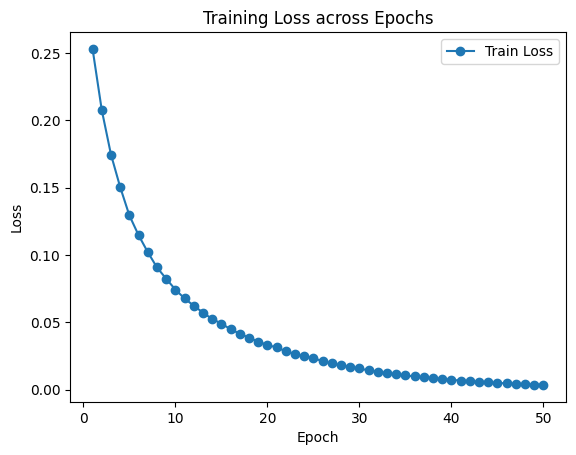

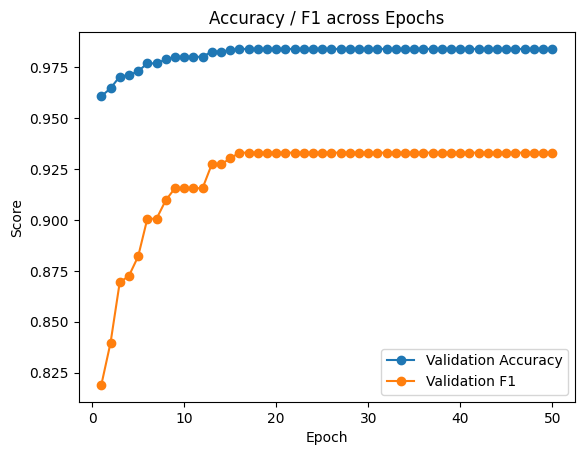

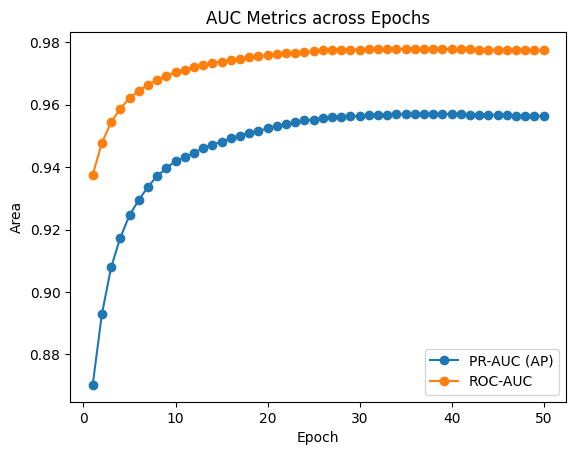

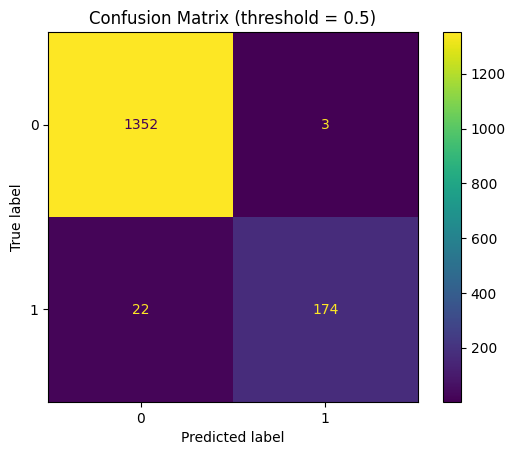

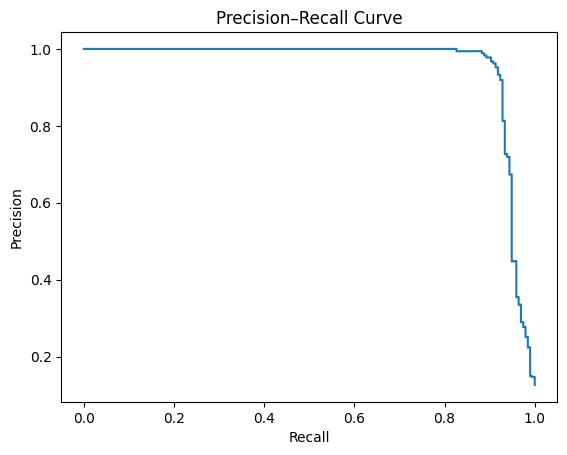

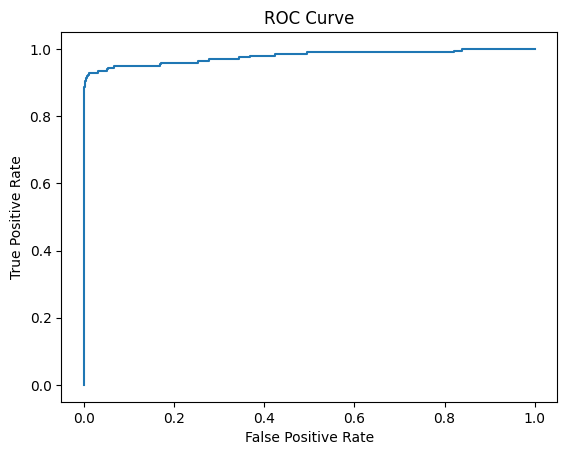

In [ ]:
import matplotlib.pyplot as plt

# --- Training loop with history tracking ---
EPOCHS = 50
history = {
    "train_loss": [],
    "val_acc": [],
    "val_f1": [],
    "val_ap": [],      # PR-AUC
    "val_roc": [],     # ROC-AUC
}

for epoch in range(EPOCHS):
    loss = train_one_epoch(model, train_loader)
    acc, prec, rec, spec, f1, roc_auc, ap = evaluate(model, test_loader)

    history["train_loss"].append(loss)
    history["val_acc"].append(acc)
    history["val_f1"].append(f1)
    history["val_ap"].append(ap)
    history["val_roc"].append(roc_auc)

    print(
        f"Epoch {epoch+1} - "
        f"Loss: {loss:.4f} | "
        f"Acc: {acc:.4f} | "
        f"Prec: {prec:.4f} | "
        f"Rec: {rec:.4f} | "
        f"Spec: {spec:.4f} | "
        f"F1: {f1:.4f} | "
        f"ROC-AUC: {roc_auc:.4f} | "
        f"PR-AUC: {ap:.4f}"
    )

# --- Plots: accuracy & loss across epochs ---
epochs = range(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], marker="o", label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss across Epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["val_acc"], marker="o", label="Validation Accuracy")
plt.plot(epochs, history["val_f1"], marker="o", label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy / F1 across Epochs")
plt.legend()
plt.show()

# Optional but recommended for spam:
plt.figure()
plt.plot(epochs, history["val_ap"], marker="o", label="PR-AUC (AP)")
plt.plot(epochs, history["val_roc"], marker="o", label="ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("Area")
plt.title("AUC Metrics across Epochs")
plt.legend()
plt.show()

# --- Final confusion matrix on the hold-out set ---
acc, prec, rec, spec, f1, roc_auc, ap, y_true, y_pred, y_prob = evaluate(
    model, test_loader, return_raw=True
)

disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()
plt.title("Confusion Matrix (threshold = 0.5)")
plt.show()

# Precision–Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
plt.figure()
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

**Model Performance Interpretation:**

The model is high-performing for spam detection:

- Accuracy: ~98%

- Precision: ~98% (very few false positives): when the model predicts "spam", it is almost always correct

- Recall: ~89% (still misses ~11% of spam, but the majority are caught)

- F1: ~0.93 (excellent balance)

- Specificity (true negative rate): nearly perfect (0.998) -> model rarely misclassified ham as spam

-> Strength: Model almost never flags ham as spam (user-friendly)

## **7. Transfer Learning (DistilBERT fine-tuning)**

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertModel
from tqdm.notebook import tqdm

In [ ]:
# 1. Train/Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["clean_text"], df["label"], test_size=0.3, stratify=df["label"], random_state=42
)

In [ ]:
# 2. Tokenize using DistilBERT's tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Convert raw text into numerical token IDs for the model
# - truncation: cut off texts longer than 64 tokens
# - padding: pad shorter texts up to 64 tokens
# - max_length: set uniform length for all sequences
# - return_tensors="pt": return as PyTorch tensors
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64, return_tensors="pt")
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=64, return_tensors="pt")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# 3. Wrap encodings & labels into a custom PyTorch Dataset
class SpamDataset(Dataset):
    def __init__(self, encodings, labels):
        # Store tokenized inputs and labels as tensors
        self.encodings = encodings
        self.labels = torch.tensor(labels.tolist(), dtype=torch.float32)

    def __getitem__(self, idx):
        # Retrieve one sample (tokenized text + label) by index
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx].unsqueeze(0) # keep label as tensor
        return item

    def __len__(self):
        # Return total number of samples
        return len(self.labels)

# Create train/test dataset objects
train_dataset = SpamDataset(train_encodings, train_labels)
test_dataset = SpamDataset(test_encodings, test_labels)


In [ ]:
# 4. Compute class weight to handle class imbalance
n_spam = train_labels.sum() # number of spam samples (positive class)
n_ham = len(train_labels) - n_spam # number of ham samples (negative class)

# pos_weight balances the loss:
# >1 if spam is underrepresented → gives spam errors more weight
pos_weight = torch.tensor([n_ham / n_spam], dtype=torch.float32)


In [ ]:
# 5. Custom DistilBERT Model with Weighted Loss
class WeightedDistilBERT(nn.Module):
    def __init__(self, model_name, pos_weight):
        super().__init__()
        # Pretrained DistilBERT backbone
        self.bert = DistilBertModel.from_pretrained(model_name)
        # Classification head: maps [CLS] embedding → single logit
        self.classifier = nn.Linear(self.bert.config.dim, 1)
        # Weighted binary cross-entropy loss to handle class imbalance
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, input_ids, attention_mask, labels=None):
        # Pass tokens through DistilBERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Extract [CLS] embedding (first token) as pooled representation
        pooled = outputs.last_hidden_state[:, 0, :]
        # Apply classification head → raw logit
        logits = self.classifier(pooled)

        if labels is not None:
            # Training mode: compute loss + return logits
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            # Inference mode: return only logits
            return {"logits": logits}


In [ ]:
# 6. Setup model, dataloaders, and optimizer

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize custom DistilBERT model with class weighting
model = WeightedDistilBERT(model_name, pos_weight.to(device)).to(device)

# DataLoaders for batching & shuffling
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer: AdamW (recommended for Transformers)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Function to evaluate model on a given dataloader

def evaluate_bert(model, dataloader, device, threshold=0.5, return_raw=False):
    model.eval() # set model to evaluation mode
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch)["logits"]
            # Convert logits → probabilities via sigmoid
            probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
            # Extract true labels
            labels = batch["labels"].squeeze(1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels)

    # Concatenate all batches
    probs  = np.concatenate(all_probs)
    labels = np.concatenate(all_labels).astype(int)
    preds  = (probs > threshold).astype(int)

    # Classification metrics
    acc  = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score(labels, preds, zero_division=0)
    f1   = f1_score(labels, preds, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    spec = tn / (tn + fp) if (tn + fp) else 0.0

    try:
        roc_auc = roc_auc_score(labels, probs)
    except ValueError:
        roc_auc = float("nan")
    pr_auc = average_precision_score(labels, probs)

    if return_raw:
        return acc, prec, rec, spec, f1, roc_auc, pr_auc, labels, preds, probs
    return acc, prec, rec, spec, f1, roc_auc, pr_auc


Epoch 1:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.2069 | Acc: 0.9877 | Prec: 0.9683 | Rec: 0.9337 | Spec: 0.9956 | F1: 0.9506 | ROC-AUC: 0.9925 | PR-AUC: 0.9852


Epoch 2:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 2 - Loss: 0.0943 | Acc: 0.9910 | Prec: 0.9789 | Rec: 0.9490 | Spec: 0.9970 | F1: 0.9637 | ROC-AUC: 0.9927 | PR-AUC: 0.9835


Epoch 3:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 3 - Loss: 0.0332 | Acc: 0.9826 | Prec: 0.8967 | Rec: 0.9745 | Spec: 0.9838 | F1: 0.9340 | ROC-AUC: 0.9943 | PR-AUC: 0.9852


Epoch 4:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 4 - Loss: 0.0245 | Acc: 0.9865 | Prec: 0.9630 | Rec: 0.9286 | Spec: 0.9948 | F1: 0.9455 | ROC-AUC: 0.9910 | PR-AUC: 0.9732


Epoch 5:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.0178 | Acc: 0.9897 | Prec: 0.9737 | Rec: 0.9439 | Spec: 0.9963 | F1: 0.9585 | ROC-AUC: 0.9969 | PR-AUC: 0.9871


Epoch 6:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.0023 | Acc: 0.9884 | Prec: 0.9635 | Rec: 0.9439 | Spec: 0.9948 | F1: 0.9536 | ROC-AUC: 0.9964 | PR-AUC: 0.9854


Epoch 7:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.0004 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9964 | PR-AUC: 0.9855


Epoch 8:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 8 - Loss: 0.0003 | Acc: 0.9884 | Prec: 0.9635 | Rec: 0.9439 | Spec: 0.9948 | F1: 0.9536 | ROC-AUC: 0.9963 | PR-AUC: 0.9855


Epoch 9:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 9 - Loss: 0.0003 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9962 | PR-AUC: 0.9854


Epoch 10:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 10 - Loss: 0.0002 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9961 | PR-AUC: 0.9853


Epoch 11:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 11 - Loss: 0.0002 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9961 | PR-AUC: 0.9853


Epoch 12:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 12 - Loss: 0.0002 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9960 | PR-AUC: 0.9853


Epoch 13:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 13 - Loss: 0.0002 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9962 | PR-AUC: 0.9856


Epoch 14:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 14 - Loss: 0.0001 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9962 | PR-AUC: 0.9856


Epoch 15:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 15 - Loss: 0.0001 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9961 | PR-AUC: 0.9856


Epoch 16:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 16 - Loss: 0.0001 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9962 | PR-AUC: 0.9857


Epoch 17:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 17 - Loss: 0.0001 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9962 | PR-AUC: 0.9857


Epoch 18:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 18 - Loss: 0.0001 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9962 | PR-AUC: 0.9857


Epoch 19:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 19 - Loss: 0.0001 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9962 | PR-AUC: 0.9856


Epoch 20:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 20 - Loss: 0.0001 | Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9962 | PR-AUC: 0.9856

Final Evaluation (threshold=0.5)
Acc: 0.9890 | Prec: 0.9686 | Rec: 0.9439 | Spec: 0.9956 | F1: 0.9561 | ROC-AUC: 0.9962 | PR-AUC: 0.9856


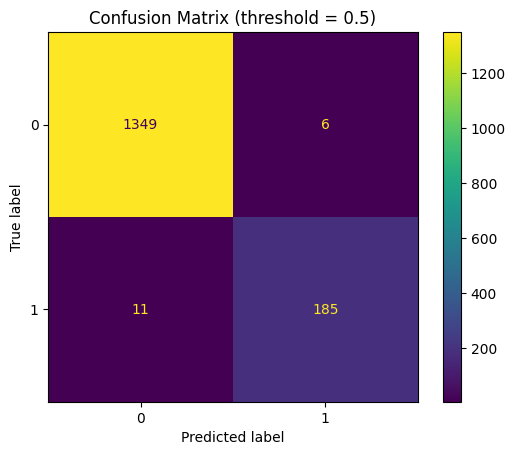

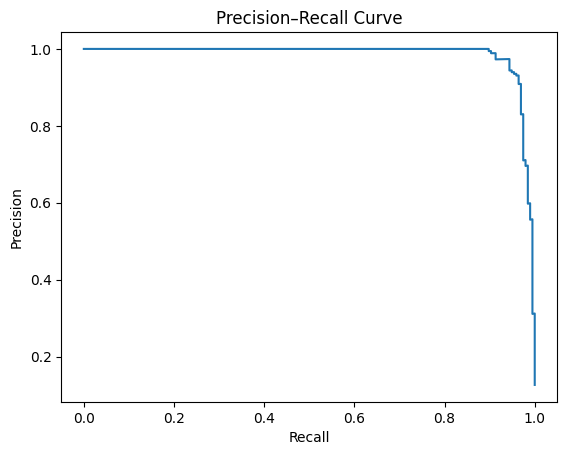

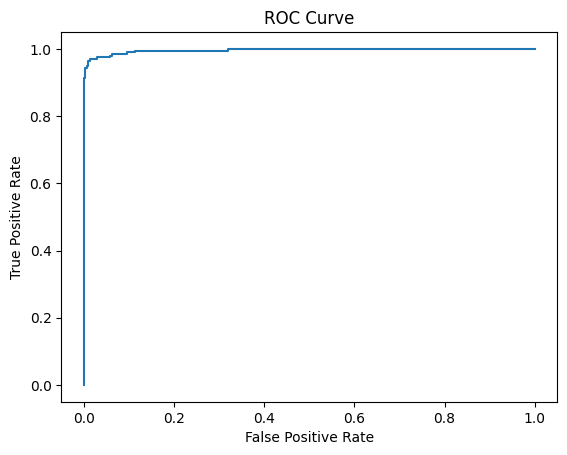

Best F1 threshold ≈ 0.535 | F1=0.9585 (P=0.974, R=0.944)


In [ ]:
# -------------------------------
# Step 7. Training Loop
# -------------------------------

EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        if batch["labels"].dim() == 1:
            batch["labels"] = batch["labels"].unsqueeze(1)

        # Forward pass
        outputs = model(**batch)
        loss = outputs["loss"]
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Live training feedback in tqdm bar
        pred_mean = torch.sigmoid(outputs["logits"]).mean().item()
        loop.set_postfix(loss=loss.item(), pred=pred_mean)

    # Average loss for the epoch
    avg_loss = total_loss / len(train_loader)

    # Evaluate on validation/test set
    acc, prec, rec, spec, f1, roc_auc, pr_auc = evaluate_bert(model, test_loader, device)

    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} | "
          f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | "
          f"Spec: {spec:.4f} | F1: {f1:.4f} | "
          f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")

# -------------------------------
# Step 8. Final Evaluation + Plots
# -------------------------------

# Get metrics + raw predictions from test set
acc, prec, rec, spec, f1, roc_auc, pr_auc, y_true, y_pred, y_prob = evaluate_bert(
    model, test_loader, device, threshold=0.5, return_raw=True
)

# Print final metrics
print(f"\nFinal Evaluation (threshold=0.5)")
print(f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | "
      f"Spec: {spec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")

# --- Visualization ---

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()
plt.title("Confusion Matrix (threshold = 0.5)")
plt.show()

# Precision–Recall Curve
precisions, recalls, pr_thresholds = precision_recall_curve(y_true, y_prob)
plt.figure()
plt.plot(recalls, precisions)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Best threshold by F1
def best_threshold_by_f1(labels, probs):
    ps, rs, ths = precision_recall_curve(labels, probs)
    f1s = 2 * ps * rs / np.clip(ps + rs, 1e-8, None)
    idx = np.nanargmax(f1s)
    return ths[idx-1] if idx > 0 else 0.5, f1s[idx], ps[idx], rs[idx]

best_th, best_f1, best_p, best_r = best_threshold_by_f1(y_true, y_prob)
print(f"Best F1 threshold ≈ {best_th:.3f} | "
      f"F1={best_f1:.4f} (P={best_p:.3f}, R={best_r:.3f})")

**Key insights:**
- Accuracy = 98.9%: Slightly higher accuracy.

- Precision = 96.9%: Still very few false positives, but slightly lower than baseline.

- Recall = 94.4%: Much stronger than baseline (catches more spam).

- Specificity = 99.6%: Still very high, almost no ham misclassified.

- F1 = 95.6%: Big improvement in the balance of precision & recall.

**Conclusion:**
- The transfer learning model (DistilBERT) clearly outperforms the baseline model:

->  Especially, it improves recall (fewer missed spam: 11 vs 22 before) while keeping precision and specificity very high.

-> The trade-off is a tiny increase in false positives (6 vs 3 before), but that’s usually acceptable in spam filtering as it's better to flag a few extra hams than miss spam.